In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [3]:
try:
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

keras = tf.keras

In [5]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [6]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset cats_vs_dogs downloaded and prepared to /Users/noh/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [7]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


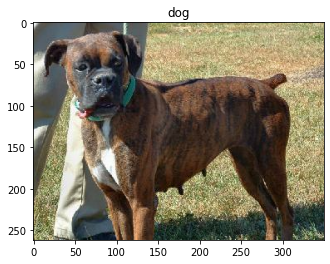

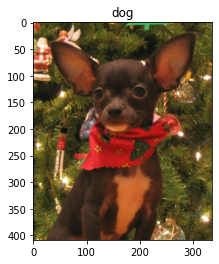

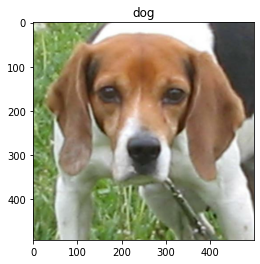

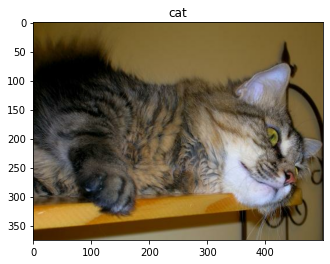

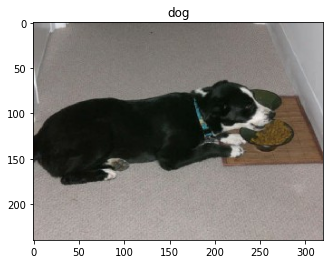

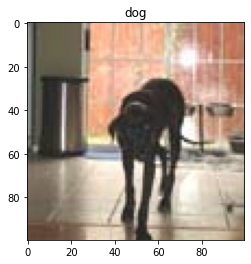

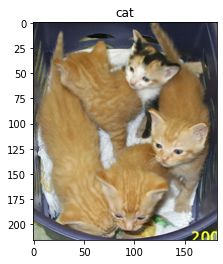

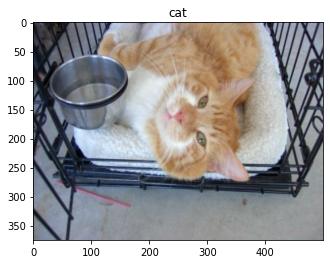

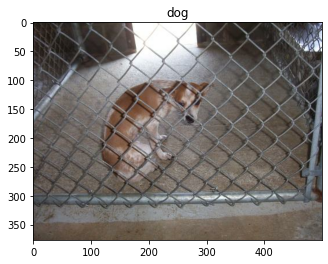

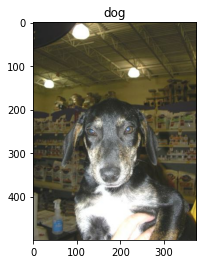

In [10]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(10):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [13]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [14]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [17]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [18]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [20]:
base_model.trainable = False

In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [24]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
len(model.trainable_variables)

2

In [28]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 6s 256ms/step - loss: 0.8348 - accuracy: 0.4484


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.45


In [30]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 199s 337ms/step - loss: 0.2410 - accuracy: 0.8862 - val_loss: 0.0938 - val_accuracy: 0.9712
Epoch 2/10
582/582 [==============================] - 175s 300ms/step - loss: 0.0751 - accuracy: 0.9735 - val_loss: 0.0652 - val_accuracy: 0.9768
Epoch 3/10
582/582 [==============================] - 182s 312ms/step - loss: 0.0589 - accuracy: 0.9789 - val_loss: 0.0564 - val_accuracy: 0.9798
Epoch 4/10
582/582 [==============================] - 174s 299ms/step - loss: 0.0525 - accuracy: 0.9808 - val_loss: 0.0524 - val_accuracy: 0.9811
Epoch 5/10
582/582 [==============================] - 174s 298ms/step - loss: 0.0488 - accuracy: 0.9823 - val_loss: 0.0498 - val_accuracy: 0.9828
Epoch 6/10
582/582 [==============================] - 175s 300ms/step - loss: 0.0465 - accuracy: 0.9832 - val_loss: 0.0479 - val_accuracy: 0.9841
Epoch 7/10
582/582 [==============================] - 176s 302ms/step - loss: 0.0447 - accuracy: 0.9837 - val_loss: 0.0471 -

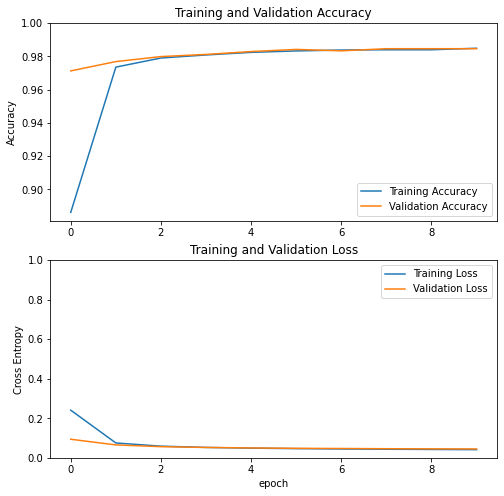

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
base_model.trainable = True

In [34]:
# 기본 모델에 몇 개의 층이 있는지 확인 합니다.
print("Number of layers in the base model: ", len(base_model.layers))

# 해당 층 이후부터 미세 조정
fine_tune_at = 100

# `fine_tune_at` 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [35]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [37]:
len(model.trainable_variables)

56

In [38]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 265s 449ms/step - loss: 0.1305 - accuracy: 0.9510 - val_loss: 0.0633 - val_accuracy: 0.9815
Epoch 11/20
582/582 [==============================] - 258s 443ms/step - loss: 0.0665 - accuracy: 0.9742 - val_loss: 0.0514 - val_accuracy: 0.9824
Epoch 12/20
582/582 [==============================] - 386s 662ms/step - loss: 0.0507 - accuracy: 0.9805 - val_loss: 0.0499 - val_accuracy: 0.9815
Epoch 13/20
582/582 [==============================] - 275s 472ms/step - loss: 0.0415 - accuracy: 0.9844 - val_loss: 0.0506 - val_accuracy: 0.9807
Epoch 14/20
582/582 [==============================] - 274s 470ms/step - loss: 0.0321 - accuracy: 0.9881 - val_loss: 0.0493 - val_accuracy: 0.9819
Epoch 15/20
582/582 [==============================] - 284s 486ms/step - loss: 0.0220 - accuracy: 0.9923 - val_loss: 0.0479 - val_accuracy: 0.9837
Epoch 16/20
582/582 [==============================] - 272s 466ms/step - loss: 0.0193 - accuracy: 0.9932 - val_loss: 0

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

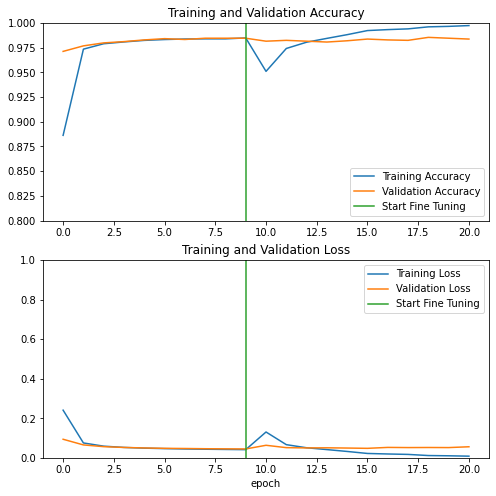

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()